In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [57]:
clients = pd.read_csv('../data/Clients.csv', delimiter=';', encoding='latin1')
commandes = pd.read_csv('../data/Commandes.csv', delimiter=';', encoding='latin1')
envois_chunks = pd.read_csv('../data/Envois.csv', delimiter=';', encoding='latin1', chunksize=500000)
envois = envois_chunks.get_chunk()
produits = pd.read_csv('../data/Produits.csv', delimiter=';', encoding='latin1')
commandes = commandes.rename(columns={'Id_produit': 'id_produit'})

In [58]:
clients["dPremierEnvoi"] = pd.to_datetime(clients["dPremierEnvoi"], errors='coerce', infer_datetime_format=True).dt.date
clients["dPremierEnvoi"]=pd.to_datetime(clients["dPremierEnvoi"])

clients["dPremiereCommande"] = pd.to_datetime(clients["dPremiereCommande"], errors='coerce', infer_datetime_format=True).dt.date
clients["dPremiereCommande"]=pd.to_datetime(clients["dPremiereCommande"])

C:\Users\mouha\AppData\Local\Temp\ipykernel_31248\1965545389.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  clients["dPremierEnvoi"] = pd.to_datetime(clients["dPremierEnvoi"], errors='coerce', infer_datetime_format=True).dt.date
C:\Users\mouha\AppData\Local\Temp\ipykernel_31248\1965545389.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  clients["dPremiereCommande"] = pd.to_datetime(clients["dPremiereCommande"], errors='coerce', infer_datetime_format=True).dt.date


C:\Users\mouha\AppData\Local\Temp\ipykernel_31248\967426701.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_segment_counts = clients.groupby(['Age Group', 'Segmentation']).size().reset_index(name='Count')


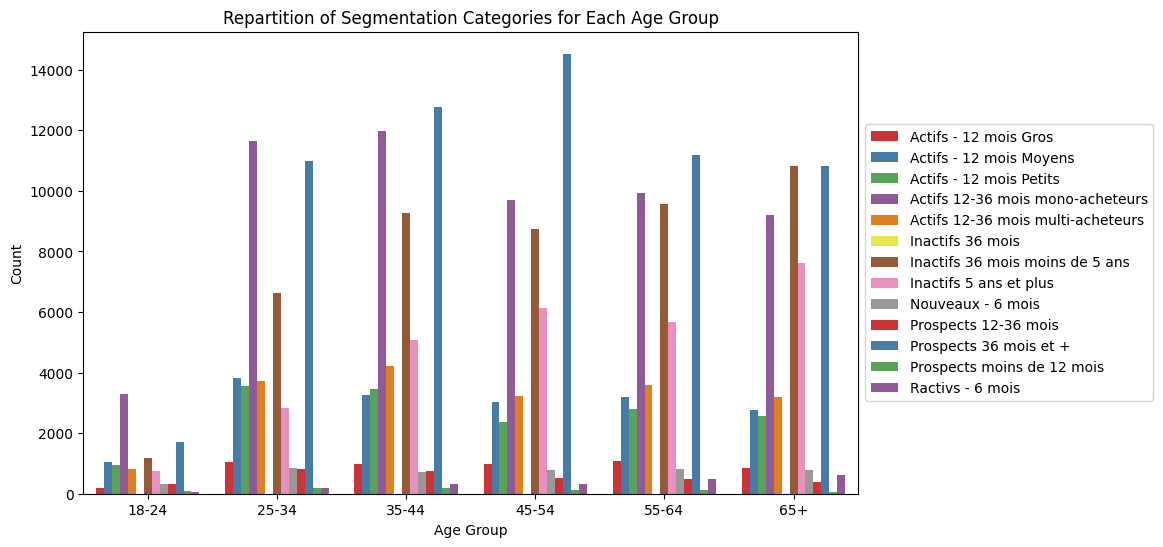

In [59]:
# Create age groups
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
clients['Age Group'] = pd.cut(clients['Age'], bins=bins, labels=labels, include_lowest=True)
# Count the number of clients in each age group and segmentation category
age_segment_counts = clients.groupby(['Age Group', 'Segmentation']).size().reset_index(name='Count')

# Create a unique plot for the distribution of segmentation categories for each age group
plt.figure(figsize=(10, 6))
sns.barplot(data=age_segment_counts, x='Age Group', y='Count', hue='Segmentation', palette='Set1')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Repartition of Segmentation Categories for Each Age Group')
plt.show()

In [60]:
#df_encoded = pd.get_dummies(clients, columns=['Civilite', 'ZoneGeographique', 'Segmentation'], drop_first=True)
#clients = pd.concat([clients, df_encoded], axis=1)
#clients = clients.drop(['Civilite', 'Pays', 'ZoneGeographique', 'Segmentation','Host'], axis=1)



In [61]:
#df2_encoded=pd.get_dummies(commandes,columns=["Canal_Commande"],drop_first=True)
#commandes=pd.concat([commandes,df2_encoded],axis=1)
#commandes=commandes.drop(["Canal_Commande"],axis=1)

In [62]:
commandes.head()

,id_produit,id_commande,id_client,quantite_produit,Canal_Commande,dCommande,Montant_Produit,Montant_Remise
0,24731,70005,207724,1,Boutique,2020-10-28 14:37:54,"105,000000",",00000000000000000"
1,8751,375150,40653,1,Boutique,2020-10-28 15:22:21,"26,250000","7,87500000000000000"
2,19462,375150,40653,1,Boutique,2020-10-28 15:22:21,"105,000000","31,50000000000000000"
3,5002,243032,485956,1,Boutique,2020-10-28 15:40:26,"113,750000",",00000000000000000"
4,2977,195454,209480,1,Boutique,2020-10-28 16:17:32,"34,125000",",00000000000000000"


In [63]:
print(commandes["dCommande"].max(),commandes["dCommande"].min())

2023-06-30 19:56:17 2020-07-01 04:41:21


In [64]:
# merge clients & commandes
merged_clients_comm = pd.merge(clients, commandes, on='id_client', how='inner')

# merge commandes & produits
merged_comm_prod = pd.merge(commandes, produits, on='id_produit', how='inner')

# merge all three tables
merged_clients_comm_prod = pd.merge(merged_clients_comm, produits, on='id_produit', how='inner')
merged_clients_comm_prod['Montant_Produit'] = merged_clients_comm_prod['Montant_Produit'].str.replace(',', '.').astype(float)
merged_clients_comm_prod['Montant_Remise'] = merged_clients_comm_prod['Montant_Remise'].str.replace(',', '.').astype(float)

In [65]:
pd.set_option("display.max_columns",100)
merged_clients_comm_prod.head()

,id_client,Host,Civilite,Pays,Age,Anciennete_Compte,ZoneGeographique,Segmentation,dPremierEnvoi,dPremiereCommande,Member_Programme_de_fid,A_ete_Membre_Programme_de_fid,Age Group,id_produit,id_commande,quantite_produit,Canal_Commande,dCommande,Montant_Produit,Montant_Remise,Annee_lancement_produit,Cible_Produit,Categorie_Produit
0,200806,gmail.com,Madame,France,69.0,8,Province Urbaine,Actifs - 12 mois Gros,2015-06-05,2015-02-28,1,0,65+,22739,353519,1,Boutique,2021-09-28 17:20:13,83.125,0.000,2020.0,Femme,Produit A
1,106492,gmail.com,Madame,France,57.0,2,NaN,Actifs 12-36 mois mono-acheteurs,2021-02-19,2021-02-18,0,0,55-64,22739,171223,1,Boutique,2021-02-18 12:17:12,83.125,0.000,2020.0,Femme,Produit A
2,72932,wanadoo.fr,Monsieur,France,66.0,7,IDF (hors Paris),Actifs 12-36 mois mono-acheteurs,NaT,2016-08-16,1,0,65+,22739,119332,1,Boutique,2022-02-10 13:42:33,36.250,0.000,2020.0,Femme,Produit A
3,387760,gmail.com,Madame,France,41.0,2,IDF (hors Paris),Actifs 12-36 mois multi-acheteurs,2021-01-21,2021-01-20,1,0,35-44,22739,11711,1,Boutique,2022-01-12 11:29:08,83.125,45.725,2020.0,Femme,Produit A
4,459987,hotmail.fr,Monsieur,France,55.0,2,Province non Urbaine,Actifs 12-36 mois mono-acheteurs,NaT,2021-02-05,0,0,45-54,22739,362831,1,Boutique,2021-02-05 12:15:42,83.125,0.000,2020.0,Femme,Produit A


Categorie_Produit
Produit A    198262
Produit B    133663
Produit C     48217
Produit D     44720
Name: count, dtype: int64


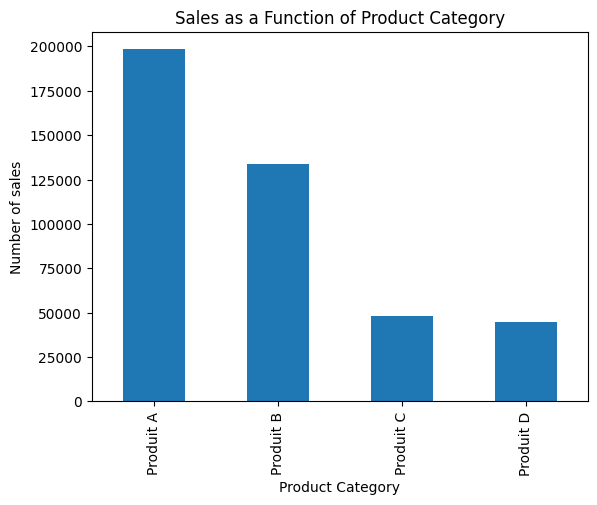

In [66]:
# Get the number of occurrences of each product type
product_counts = merged_clients_comm_prod['Categorie_Produit'].value_counts()

print(product_counts)
product_counts.plot(kind='bar')
plt.xlabel('Product Category')
plt.ylabel('Number of sales')
plt.title('Sales as a Function of Product Category')
plt.show()

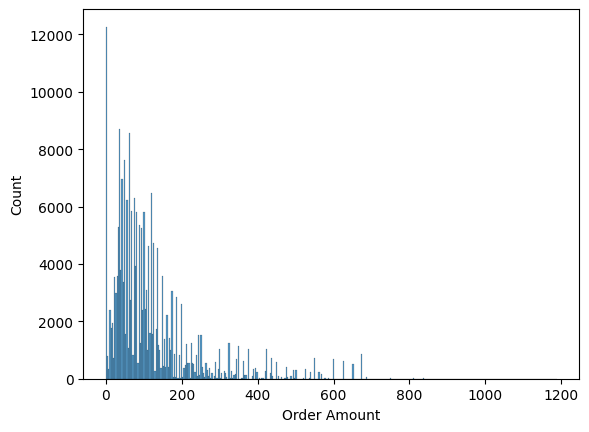

118.03170283985986


In [67]:
# Filter the data to only include punctual buyers who have made 3 or less commands
punctual_buyers = merged_clients_comm_prod.groupby('id_client').filter(lambda x: len(x) <= 3)

# Plot the distribution of order amounts for punctual buyers
sns.histplot(data=punctual_buyers, x='Montant_Produit', kde=False)
plt.xlabel('Order Amount')
plt.ylabel('Count')
plt.show()

mean_punctual = punctual_buyers['Montant_Produit'].mean()
print(mean_punctual)

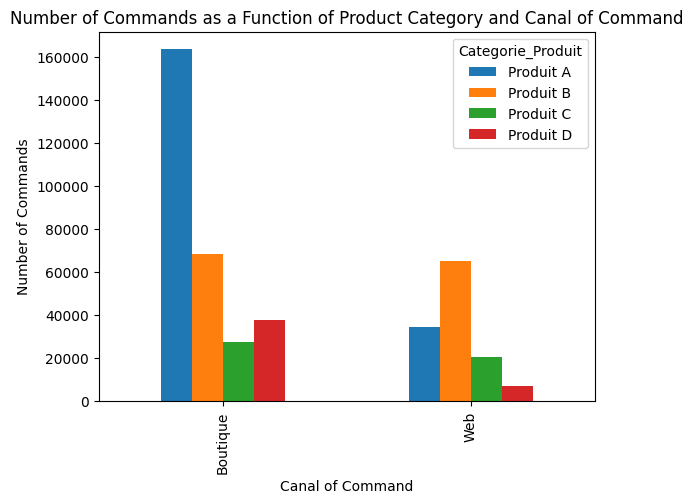

In [68]:
# Create a pivot table with the number of commands for each product category and canal of command
command_counts = merged_comm_prod.pivot_table(index='Canal_Commande', columns='Categorie_Produit', values='id_commande', aggfunc='count')

# Create a bar plot of the pivot table
command_counts.plot(kind='bar')
plt.xlabel('Canal of Command')
plt.ylabel('Number of Commands')
plt.title('Number of Commands as a Function of Product Category and Canal of Command')
plt.show()

In [69]:
# Calculate mean amount spent per client as a function of age group
mean_amounts = merged_clients_comm_prod.groupby('Age Group')['Montant_Produit'].mean()

# Plot the mean amount spent per client as a function of age group
"""plt.plot(mean_amounts.index, mean_amounts.values)
plt.xlabel('Age Group')
plt.ylabel('Mean Amount Spent per Client')
plt.title('Mean Amount Spent per Client as a Function of Age Group')
plt.show()"""
print(mean_amounts)

Age Group
18-24    115.171442
25-34    107.545066
35-44     99.841876
45-54    113.358810
55-64    110.211297
65+      110.122101
Name: Montant_Produit, dtype: float64


C:\Users\mouha\AppData\Local\Temp\ipykernel_31248\2390322860.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_amounts = merged_clients_comm_prod.groupby('Age Group')['Montant_Produit'].mean()


# VALIDATION

In [70]:
data_df = merged_clients_comm_prod.copy()
data_df.head()

,id_client,Host,Civilite,Pays,Age,Anciennete_Compte,ZoneGeographique,Segmentation,dPremierEnvoi,dPremiereCommande,Member_Programme_de_fid,A_ete_Membre_Programme_de_fid,Age Group,id_produit,id_commande,quantite_produit,Canal_Commande,dCommande,Montant_Produit,Montant_Remise,Annee_lancement_produit,Cible_Produit,Categorie_Produit
0,200806,gmail.com,Madame,France,69.0,8,Province Urbaine,Actifs - 12 mois Gros,2015-06-05,2015-02-28,1,0,65+,22739,353519,1,Boutique,2021-09-28 17:20:13,83.125,0.000,2020.0,Femme,Produit A
1,106492,gmail.com,Madame,France,57.0,2,NaN,Actifs 12-36 mois mono-acheteurs,2021-02-19,2021-02-18,0,0,55-64,22739,171223,1,Boutique,2021-02-18 12:17:12,83.125,0.000,2020.0,Femme,Produit A
2,72932,wanadoo.fr,Monsieur,France,66.0,7,IDF (hors Paris),Actifs 12-36 mois mono-acheteurs,NaT,2016-08-16,1,0,65+,22739,119332,1,Boutique,2022-02-10 13:42:33,36.250,0.000,2020.0,Femme,Produit A
3,387760,gmail.com,Madame,France,41.0,2,IDF (hors Paris),Actifs 12-36 mois multi-acheteurs,2021-01-21,2021-01-20,1,0,35-44,22739,11711,1,Boutique,2022-01-12 11:29:08,83.125,45.725,2020.0,Femme,Produit A
4,459987,hotmail.fr,Monsieur,France,55.0,2,Province non Urbaine,Actifs 12-36 mois mono-acheteurs,NaT,2021-02-05,0,0,45-54,22739,362831,1,Boutique,2021-02-05 12:15:42,83.125,0.000,2020.0,Femme,Produit A


In [71]:

# Count of orders by Boutique and Web per client
web_counts = data_df[data_df['Canal_Commande'] == 'Web'].groupby('id_client').size().reset_index(name='Web_Count')
boutique_counts = data_df[data_df['Canal_Commande'] == 'Boutique'].groupby('id_client').size().reset_index(name='Boutique_Count')

result = pd.merge(web_counts, boutique_counts, on='id_client', how='outer').fillna(0).astype(int)

# nombre total de commandes dans les 12, 6 et 3 derniers mois
count_orders_year = data_df[data_df['dCommande'] > '2022-07-01'].groupby('id_client').size().reset_index(name='Count_Orders_year')
count_orders_6 = data_df[data_df['dCommande'] > '2023-01-01'].groupby('id_client').size().reset_index(name='Count_Orders_6months')
count_orders_3 = data_df[data_df['dCommande'] > '2023-04-01'].groupby('id_client').size().reset_index(name='Count_Orders_3months')

# Total amount spent per id_client
amount_spent = data_df.groupby('id_client')['Montant_Produit'].sum().reset_index(name='Total_Amount_Spent')

# Count of products bought in their launch year
data_df['Year'] = pd.to_datetime(data_df['dCommande']).dt.year
count_orders_launch_year = data_df[data_df['Year'] == data_df['Annee_lancement_produit']].groupby('id_client').size().reset_index(name='Count_Orders_Launch_Year')

result = pd.merge(result, count_orders_year, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_3, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_6, on='id_client', how='inner').astype(int)
result = pd.merge(result, amount_spent, on='id_client', how='inner').astype(float)
result = pd.merge(result, count_orders_launch_year, on='id_client', how='inner').astype(int)

# Count of orders placed after a limit date
limit_date = '2023-01-01'

orders_after = data_df[data_df['dCommande'] >= limit_date]
order_counts = orders_after.groupby('id_client').size().reset_index(name='Orders_After')

result = pd.merge(result, order_counts, on='id_client', how='inner')


# Final merge 
dataset_af = pd.merge(clients, result, on='id_client', how='inner')

#dataset_af['dPremierEnvoi'] = pd.to_datetime(dataset_af['dPremierEnvoi']).dt.date()
#dataset_af['dPremiereCommande'] = pd.to_datetime(dataset_af['dPremiereCommande']).dt.date()

dataset_af = dataset_af.dropna(subset=['dPremierEnvoi', 'dPremiereCommande'])
dataset_af = dataset_af.dropna()
dataset_af = pd.get_dummies(dataset_af, columns=['Segmentation'])



In [72]:
# Filter the data based on the date of the commandes
train_date = '2023-04-01'
data_bf = merged_clients_comm_prod.copy()[merged_clients_comm_prod['dCommande'] <= train_date]

# Count of orders by Boutique and Web per client
web_counts = data_bf[data_bf['Canal_Commande'] == 'Web'].groupby('id_client').size().reset_index(name='Web_Count')
boutique_counts = data_bf[data_bf['Canal_Commande'] == 'Boutique'].groupby('id_client').size().reset_index(name='Boutique_Count')

result = pd.merge(web_counts, boutique_counts, on='id_client', how='outer').fillna(0).astype(int)

# nombre total de commandes dans les 12, 6 et 3 derniers mois
count_orders_year = data_bf[data_bf['dCommande'] > '2022-04-01'].groupby('id_client').size().reset_index(name='Count_Orders_year')
count_orders_6 = data_bf[data_bf['dCommande'] > '2022-10-01'].groupby('id_client').size().reset_index(name='Count_Orders_6months')
count_orders_3 = data_bf[data_bf['dCommande'] > '2023-01-01'].groupby('id_client').size().reset_index(name='Count_Orders_3months')

# Total amount spent per id_client
amount_spent = data_bf.groupby('id_client')['Montant_Produit'].sum().reset_index(name='Total_Amount_Spent')

# Count of products bought in their launch year
data_bf['Year'] = pd.to_datetime(data_bf['dCommande']).dt.year
count_orders_launch_year = data_bf[data_bf['Year'] == data_bf['Annee_lancement_produit']].groupby('id_client').size().reset_index(name='Count_Orders_Launch_Year')

In [73]:


result = pd.merge(result, count_orders_year, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_3, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_6, on='id_client', how='inner').astype(int)
result = pd.merge(result, amount_spent, on='id_client', how='inner').astype(float)
result = pd.merge(result, count_orders_launch_year, on='id_client', how='inner').astype(int)

# Count of orders placed after a limit date
limit_date = '2023-01-01'

orders_after = data_bf[data_bf['dCommande'] >= limit_date]
order_counts = orders_after.groupby('id_client').size().reset_index(name='Orders_After')

result = pd.merge(result, order_counts, on='id_client', how='inner')

# Final merge 
dataset_bf = pd.merge(clients, result, on='id_client', how='inner')

dataset_bf['dPremierEnvoi'] = pd.to_datetime(dataset_bf['dPremierEnvoi'])
dataset_bf['dPremiereCommande'] = pd.to_datetime(dataset_bf['dPremiereCommande'])

dataset_bf = dataset_bf.dropna()

dataset_bf = pd.get_dummies(dataset_bf, columns=['Segmentation'])

dataset_bf['Segmentation_Actifs 12-36 mois multi-acheteurs'] = 0
dataset_bf['Segmentation_Nouveaux - 6 mois'] = 0
dataset_bf['Segmentation_Ractivs - 6 mois'] = 0

print(dataset_bf.columns)

Index(['id_client', 'Host', 'Civilite', 'Pays', 'Age', 'Anciennete_Compte',
       'ZoneGeographique', 'dPremierEnvoi', 'dPremiereCommande',
       'Member_Programme_de_fid', 'A_ete_Membre_Programme_de_fid', 'Age Group',
       'Web_Count', 'Boutique_Count', 'Count_Orders_year',
       'Count_Orders_3months', 'Count_Orders_6months', 'Total_Amount_Spent',
       'Count_Orders_Launch_Year', 'Orders_After',
       'Segmentation_Actifs - 12 mois Gros',
       'Segmentation_Actifs - 12 mois Moyens',
       'Segmentation_Actifs - 12 mois Petits',
       'Segmentation_Actifs 12-36 mois mono-acheteurs',
       'Segmentation_Actifs 12-36 mois multi-acheteurs',
       'Segmentation_Nouveaux - 6 mois', 'Segmentation_Ractivs - 6 mois'],
      dtype='object')


In [74]:
# Step 1: Preprocess the data

# Drop unnecessary columns
cols_to_drop = ['id_client', 'Host', 'Civilite', 'Age Group', 'ZoneGeographique', 'Pays', 'dPremierEnvoi', 'dPremiereCommande']
dataset_bf = dataset_bf.drop(cols_to_drop, axis=1, errors='ignore')

# Normalize numerical variables
scaler = StandardScaler()
numerical_cols = ['Web_Count', 'Boutique_Count', 'Count_Orders_year', 'Count_Orders_3months', 'Count_Orders_6months', 'Total_Amount_Spent', 
                  'Count_Orders_Launch_Year']
dataset_bf[numerical_cols] = scaler.fit_transform(dataset_bf[numerical_cols])

# Split the data into training and validation sets
train_data, test_data = train_test_split(dataset_bf, test_size=0.2, random_state=42)

# Step 2: Build the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 3: Train the model
train_inputs = train_data.drop('Orders_After', axis=1)
train_labels = train_data['Orders_After']
test_inputs = test_data.drop('Orders_After', axis=1)
test_labels = test_data['Orders_After']

model.fit(train_inputs, train_labels)

# Step 4: Test the model

# Preprocess the validation data 
test_data = test_data.drop(cols_to_drop, axis=1, errors='ignore')
test_data[numerical_cols] = scaler.fit_transform(test_data[numerical_cols])

# Use the trained model to make predictions on the validation data
predictions = model.predict(test_inputs)

# Get the actual labels from the validation dataset
accuracy = accuracy_score(test_labels, predictions)
accuracy

0.9519230769230769

In [75]:
from sklearn.svm import SVC

# Step 1: Preprocess the data (same as before)

# Step 2: Build the model
model = SVC(kernel='linear', random_state=42)

# Step 3: Train the model (same as before)
model.fit(train_inputs, train_labels)

# Step 4: Test the model on 'dataset' (same as before)
predictions = model.predict(test_inputs)

# Calculate the accuracy of the model (same as before)
accuracy = accuracy_score(test_labels, predictions)
accuracy


0.9615384615384616

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Step 1: Preprocess the data (same as before)

# Step 2: Build the model
model = DecisionTreeClassifier(random_state=42)

# Step 3: Train the model (same as before)
model.fit(train_inputs, train_labels)

# Step 4: Test the model on 'dataset' (same as before)
predictions = model.predict(test_inputs)

# Calculate the accuracy of the model (same as before)
accuracy = accuracy_score(test_labels, predictions)
accuracy


0.9935897435897436

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

# Step 1: Preprocess the data (same as before)

# Step 2: Build the model
model = GradientBoostingClassifier(random_state=42)

# Step 3: Train the model (same as before)
model.fit(train_inputs, train_labels)

# Step 4: Test the model on 'dataset' (same as before)
predictions = model.predict(test_inputs)

# Calculate the accuracy of the model (same as before)
accuracy = accuracy_score(test_labels, predictions)
accuracy


0.9967948717948718

## Regression Logistique

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Preprocess the data (same as before)

# Step 2: Build the model
model = LogisticRegression(random_state=42,max_iter=10000)

# Step 3: Train the model (same as before)
model.fit(train_inputs, train_labels)

# Step 4: Test the model on 'dataset' (same as before)
predictions = model.predict(test_inputs)

# Calculate the accuracy of the model (same as before)
accuracy = accuracy_score(test_labels, predictions)
accuracy


0.8076923076923077

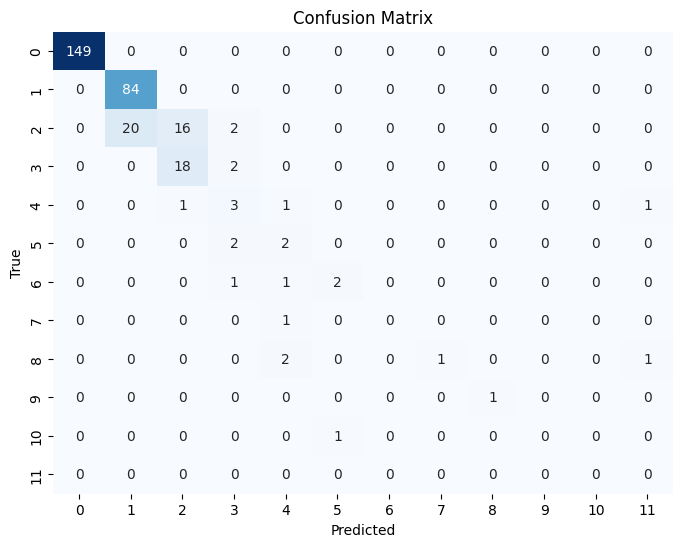

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Create a confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [89]:
from sklearn.metrics import roc_curve, auc

# Assuming 'model' is your logistic regression model
probabilities = model.predict_proba(test_inputs)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


ValueError: multiclass format is not supported

In [90]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming 'model' is your logistic regression model
probabilities = model.predict_proba(test_inputs)[:, 1]

# Compute precision-recall curve and area under the curve
precision, recall, _ = precision_recall_curve(test_labels, probabilities)
average_precision = average_precision_score(test_labels, probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={:.2f}'.format(average_precision))
plt.show()


ValueError: multiclass format is not supported

## NN

In [77]:


# Step 1: Preprocess the data (same as before)
input_size = train_inputs.shape[1]  # Using shape[1] to get the number of columns

# Convert the input data to tensors
train_inputs_tensor = torch.tensor(train_inputs.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.float32).view(-1, 1)  # Reshape the labels
test_inputs_tensor = torch.tensor(test_inputs.values, dtype=torch.float32)

# Step 2: Build the model
model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)  # Removed Sigmoid for regression
)

# Step 3: Train the model (same as before)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in zip(train_inputs_tensor, train_labels_tensor):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_inputs_tensor)}")

# Step 4: Test the model on 'val_inputs_tensor'
with torch.no_grad():
    predictions = model(test_inputs_tensor)

# Convert predictions and labels to numpy arrays for easier evaluation
predictions_np = predictions.numpy()

# Evaluate your regression model using appropriate metrics (e.g., Mean Absolute Error, Mean Squared Error)
mae = mean_absolute_error(test_labels, predictions_np)
mse = mean_squared_error(test_labels, predictions_np)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have your features and labels ready
# X_train, y_train, X_test, y_test = ...

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(train_inputs.values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32).view(-1, 1)  # Assuming binary classification
X_test_tensor = torch.tensor(test_inputs.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32).view(-1, 1)  # Assuming binary classification

# Step 1: Preprocess the data (if needed)

# Step 2: Build the deep learning model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = NeuralNetwork(train_inputs.shape[1])

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 3: Train the model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size].to(device)
        labels = y_train_tensor[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Step 4: Test the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor.to(device))
    predictions = (outputs > 0.5).cpu().numpy().astype(int).flatten()

# Calculate the accuracy of the model
accuracy = accuracy_score(test_labels, predictions)
print("Test Set Accuracy:", accuracy)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.